In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Estilo profesional oscuro
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor']   = '#1a1d2e'
plt.rcParams['axes.labelcolor']  = 'white'
plt.rcParams['xtick.color']      = 'white'
plt.rcParams['ytick.color']      = 'white'
plt.rcParams['text.color']       = 'white'
plt.rcParams['grid.color']       = '#2d2d2d'
plt.rcParams['grid.alpha']       = 0.4

# ✅ RUTAS DEL PROYECTO
PROJECT_ROOT = r"C:\Users\matup\OneDrive\Documentos\sistema_de_Predicción_de_Fallos_en_Última Milla"
DATA_RAW     = os.path.join(PROJECT_ROOT, "data", "raw", "dataset_distribucion_nacional2.csv")
DATA_EXT     = os.path.join(PROJECT_ROOT, "data", "external")
FIGURES_PATH = os.path.join(PROJECT_ROOT, "outputnts", "figures")
REPORTS_PATH = os.path.join(PROJECT_ROOT, "outputnts", "reports")

# Crear carpetas si no existen
for carpeta in [FIGURES_PATH, REPORTS_PATH]:
    os.makedirs(carpeta, exist_ok=True)

# ✅ Cargar dataset principal
df = pd.read_csv(DATA_RAW)
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])

# ✅ Cargar feriados si existe el archivo
feriados_path = os.path.join(DATA_EXT, "feriados_argentina.csv")
if os.path.exists(feriados_path):
    df_feriados = pd.read_csv(feriados_path)
    print("✅ Feriados cargados:", df_feriados.shape)
else:
    print("⚠️  Feriados no encontrados, continuamos sin ellos")
    df_feriados = None

print("✅ Dataset cargado correctamente")
print(f"   Filas    : {len(df):,}")
print(f"   Columnas : {len(df.columns)}")
print(f"   Período  : {df['fecha_envio'].min().date()} → {df['fecha_envio'].max().date()}")

⚠️  Feriados no encontrados, continuamos sin ellos
✅ Dataset cargado correctamente
   Filas    : 500,000
   Columnas : 23
   Período  : 2022-01-01 → 2024-12-31


In [2]:
print("=" * 60)
print("📋 DIAGNÓSTICO INICIAL DEL DATASET")
print("=" * 60)

print("\n📌 Columnas y tipos de datos:")
print(df.dtypes)

print("\n📌 Valores nulos por columna:")
nulos = df.isnull().sum()
nulos_pct = (nulos / len(df) * 100).round(2)
resumen_nulos = pd.DataFrame({'Nulos': nulos, 'Porcentaje %': nulos_pct})
print(resumen_nulos[resumen_nulos['Nulos'] > 0])

print("\n📌 Estadísticas numéricas:")
print(df.describe().round(2))

print("\n📌 Duplicados:", df.duplicated().sum())
print("\n📌 Memoria del dataset:",
      f"{df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

📋 DIAGNÓSTICO INICIAL DEL DATASET

📌 Columnas y tipos de datos:
shipment_id                       int64
fecha_envio              datetime64[us]
provincia                           str
latitud                         float64
longitud                        float64
zona                                str
zona_peligrosa                    int64
clima                               str
evento_especial                     str
tipo_cliente                        str
transportista                       str
chofer                              str
distancia_km                    float64
tiempo_estimado_horas           float64
tiempo_real_horas               float64
demora_horas                    float64
estado                              str
motivo_fallo                        str
costo_envio                     float64
entrega_exitosa                   int64
mes                               int64
anio                              int64
dia_semana                          str
dtype: object

📌

In [3]:
print("=" * 60)
print("🔍 ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("=" * 60)

categoricas = ['transportista', 'estado', 'zona', 'tipo_cliente',
               'provincia', 'clima', 'evento_especial', 'dia_semana']

for col in categoricas:
    if col in df.columns:
        print(f"\n📌 {col.upper()}:")
        print(df[col].value_counts().to_string())

🔍 ANÁLISIS DE VARIABLES CATEGÓRICAS

📌 TRANSPORTISTA:
transportista
OCA                 149859
Andreani            125797
Correo Argentino     99579
DHL                  74778
FedEx                49987

📌 ESTADO:
estado
Entregado    389506
Demorado      71521
Perdido       22978
Devuelto      15995

📌 ZONA:
zona
Urbana            231524
Suburbana         124467
Rural             100132
Zona Peligrosa     43877

📌 TIPO_CLIENTE:
tipo_cliente
Empresa       250034
Particular    174970
Pyme           74996

📌 PROVINCIA:
provincia
Córdoba             33612
Santa Fe            33414
Chaco               33384
Tierra del Fuego    33382
La Plata            33381
Mar del Plata       33375
Tucumán             33368
Jujuy               33367
Salta               33332
Entre Ríos          33323
Misiones            33318
Rosario             33304
Mendoza             33262
Neuquén             33170
Buenos Aires        33008

📌 CLIMA:
clima
Soleado        128263
Nublado         89575
Caluroso        63

In [4]:
print("=" * 60)
print("🎯 KPIs PRINCIPALES — SISTEMA DE PREDICCIÓN DE FALLOS")
print("=" * 60)

# KPI 1 — Tasa de entrega exitosa
tasa_global = df['entrega_exitosa'].mean()

# KPI 2 — Costo total de envíos fallidos
df_fallidos = df[df['entrega_exitosa'] == 0]
costo_fallidos = df_fallidos['costo_envio'].sum()

# KPI 3 — Transportista con mejor performance
mejor_trans = df.groupby('transportista')['entrega_exitosa'].mean().idxmax()
mejor_tasa  = df.groupby('transportista')['entrega_exitosa'].mean().max()

# KPI 4 — Peor zona
peor_zona     = df.groupby('zona')['entrega_exitosa'].mean().idxmin()
peor_zona_tasa = df.groupby('zona')['entrega_exitosa'].mean().min()

# KPI 5 — Evento con más envíos
top_evento = df['evento_especial'].value_counts().idxmax()

# KPI 6 — Demora promedio por clima adverso
clima_adverso = ['Tormentoso', 'Nieve', 'Lluvioso', 'Neblina']
demora_clima  = df[df['clima'].isin(clima_adverso)]['demora_horas'].mean()
demora_normal = df[~df['clima'].isin(clima_adverso)]['demora_horas'].mean()

print(f"""
┌─────────────────────────────────────────────────────┐
│  📦 Total envíos analizados : {len(df):>15,}         │
│  ✅ Tasa entrega exitosa    : {tasa_global:>14.1%}         │
│  ❌ Total envíos fallidos   : {len(df_fallidos):>15,}         │
│  💸 Costo total fallidos    : ${costo_fallidos:>14,.0f}         │
│  🏆 Mejor transportista     : {mejor_trans:>15} ({mejor_tasa:.1%})  │
│  ⚠️  Zona más problemática   : {peor_zona:>15} ({peor_zona_tasa:.1%})  │
│  📅 Evento con más envíos   : {top_evento:>15}         │
│  🌧️  Demora clima adverso    : {demora_clima:>14.2f} hs        │
│  ☀️  Demora clima normal     : {demora_normal:>14.2f} hs        │
└─────────────────────────────────────────────────────┘
""")

# Guardar KPIs en CSV
kpis_df = pd.DataFrame({
    'KPI': ['Total Envíos', 'Tasa Éxito', 'Envíos Fallidos',
            'Costo Fallidos', 'Mejor Transportista', 'Peor Zona',
            'Demora Clima Adverso', 'Demora Clima Normal'],
    'Valor': [len(df), f"{tasa_global:.1%}", len(df_fallidos),
              f"${costo_fallidos:,.0f}", f"{mejor_trans} ({mejor_tasa:.1%})",
              f"{peor_zona} ({peor_zona_tasa:.1%})",
              f"{demora_clima:.2f} hs", f"{demora_normal:.2f} hs"]
})
kpis_df.to_csv(os.path.join(REPORTS_PATH, "kpis_principales.csv"), index=False)
print("✅ KPIs guardados en outputnts/reports/kpis_principales.csv")

🎯 KPIs PRINCIPALES — SISTEMA DE PREDICCIÓN DE FALLOS

┌─────────────────────────────────────────────────────┐
│  📦 Total envíos analizados :         500,000         │
│  ✅ Tasa entrega exitosa    :          77.9%         │
│  ❌ Total envíos fallidos   :         110,494         │
│  💸 Costo total fallidos    : $ 1,034,631,341         │
│  🏆 Mejor transportista     :             OCA (78.1%)  │
│  ⚠️  Zona más problemática   :  Zona Peligrosa (48.9%)  │
│  📅 Evento con más envíos   :          Normal         │
│  🌧️  Demora clima adverso    :           2.37 hs        │
│  ☀️  Demora clima normal     :           1.12 hs        │
└─────────────────────────────────────────────────────┘

✅ KPIs guardados en outputnts/reports/kpis_principales.csv


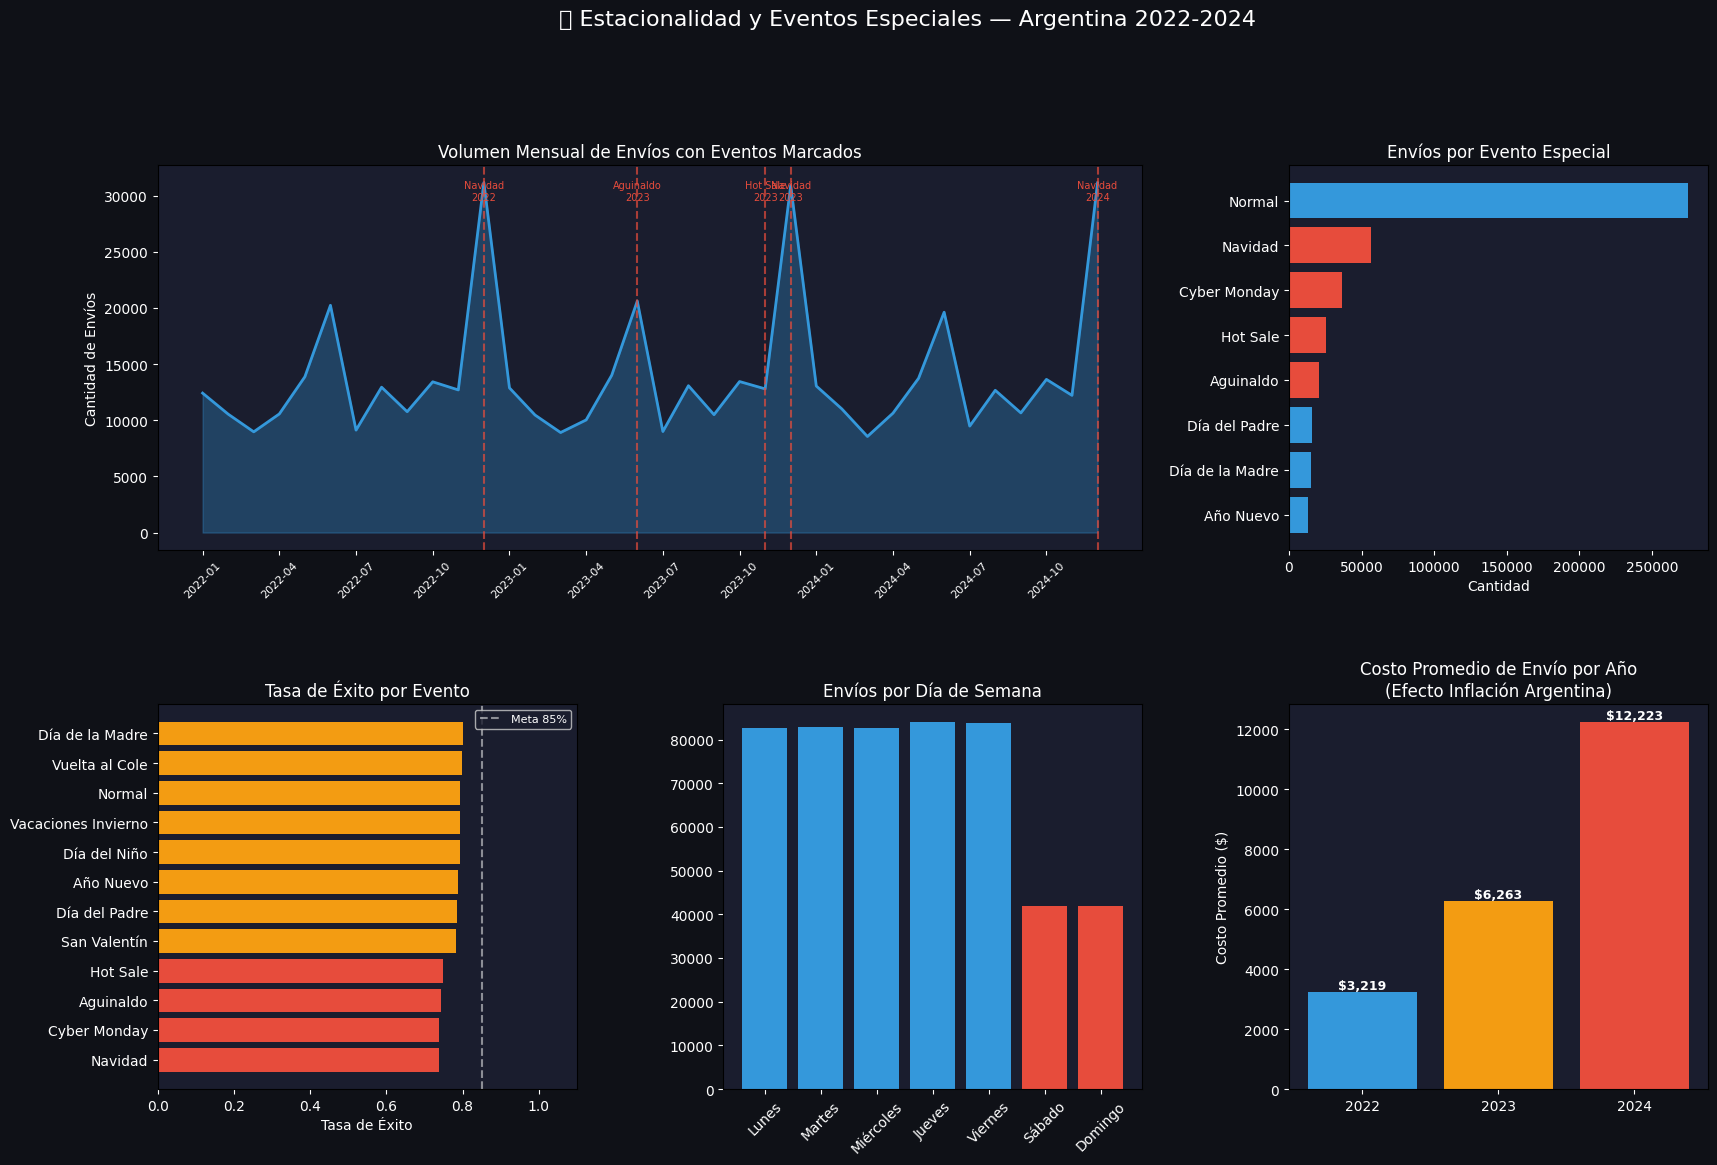

✅ Guardado: 01_estacionalidad_eventos.png


In [5]:
fig = plt.figure(figsize=(20, 12))
fig.suptitle('📅 Estacionalidad y Eventos Especiales — Argentina 2022-2024',
             fontsize=16, y=1.01)

gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# ── 1. Envíos por mes con eventos marcados ────────────────
ax1 = fig.add_subplot(gs[0, :2])
envios_mes = df.groupby(df['fecha_envio'].dt.to_period('M')).size()
envios_mes.index = envios_mes.index.astype(str)

ax1.fill_between(range(len(envios_mes)), envios_mes.values,
                  alpha=0.3, color='#3498db')
ax1.plot(range(len(envios_mes)), envios_mes.values,
         color='#3498db', linewidth=2)

# Marcar eventos importantes
eventos_marcar = {
    'Navidad\n2022': '2022-12',
    'Navidad\n2023': '2023-12',
    'Navidad\n2024': '2024-12',
    'Aguinaldo\n2023': '2023-06',
    'Hot Sale\n2023': '2023-11',
}
for label, periodo in eventos_marcar.items():
    if periodo in list(envios_mes.index):
        idx = list(envios_mes.index).index(periodo)
        ax1.axvline(x=idx, color='#e74c3c', linestyle='--', alpha=0.7)
        ax1.text(idx, envios_mes.max() * 0.95, label,
                 ha='center', fontsize=7, color='#e74c3c')

ax1.set_title('Volumen Mensual de Envíos con Eventos Marcados')
ax1.set_xticks(range(0, len(envios_mes), 3))
ax1.set_xticklabels(list(envios_mes.index)[::3], rotation=45, fontsize=8)
ax1.set_ylabel('Cantidad de Envíos')

# ── 2. Envíos por evento especial ────────────────────────
ax2 = fig.add_subplot(gs[0, 2])
eventos = df['evento_especial'].value_counts().head(8)
colores_ev = ['#e74c3c' if e in ['Navidad', 'Cyber Monday', 'Hot Sale', 'Aguinaldo']
              else '#3498db' for e in eventos.index]
ax2.barh(eventos.index[::-1], eventos.values[::-1], color=colores_ev[::-1])
ax2.set_title('Envíos por Evento Especial')
ax2.set_xlabel('Cantidad')

# ── 3. Tasa éxito por evento ──────────────────────────────
ax3 = fig.add_subplot(gs[1, 0])
tasa_evento = df.groupby('evento_especial')['entrega_exitosa'].mean().sort_values()
colores_te  = ['#e74c3c' if t < 0.75 else '#f39c12'
               if t < 0.85 else '#2ecc71' for t in tasa_evento]
ax3.barh(tasa_evento.index, tasa_evento.values, color=colores_te)
ax3.axvline(x=0.85, color='white', linestyle='--', alpha=0.5, label='Meta 85%')
ax3.set_title('Tasa de Éxito por Evento')
ax3.set_xlabel('Tasa de Éxito')
ax3.set_xlim(0, 1.1)
ax3.legend(fontsize=8)

# ── 4. Envíos por día de semana ───────────────────────────
ax4 = fig.add_subplot(gs[1, 1])
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
              'Friday', 'Saturday', 'Sunday']
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves',
                'Viernes', 'Sábado', 'Domingo']
if 'dia_semana' in df.columns:
    dias = df['dia_semana'].value_counts().reindex(orden_dias)
    ax4.bar(nombres_dias, dias.values,
            color=['#3498db']*5 + ['#e74c3c']*2)
    ax4.set_title('Envíos por Día de Semana')
    ax4.set_xlabel('')
    ax4.tick_params(axis='x', rotation=45)

# ── 5. Inflación en costo de envío por año ────────────────
ax5 = fig.add_subplot(gs[1, 2])
costo_anio = df.groupby('anio')['costo_envio'].mean()
bars = ax5.bar(costo_anio.index.astype(str), costo_anio.values,
               color=['#3498db', '#f39c12', '#e74c3c'])
for bar, val in zip(bars, costo_anio.values):
    ax5.text(bar.get_x() + bar.get_width()/2, val + 100,
             f'${val:,.0f}', ha='center', fontsize=9, fontweight='bold')
ax5.set_title('Costo Promedio de Envío por Año\n(Efecto Inflación Argentina)')
ax5.set_ylabel('Costo Promedio ($)')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "01_estacionalidad_eventos.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: 01_estacionalidad_eventos.png")

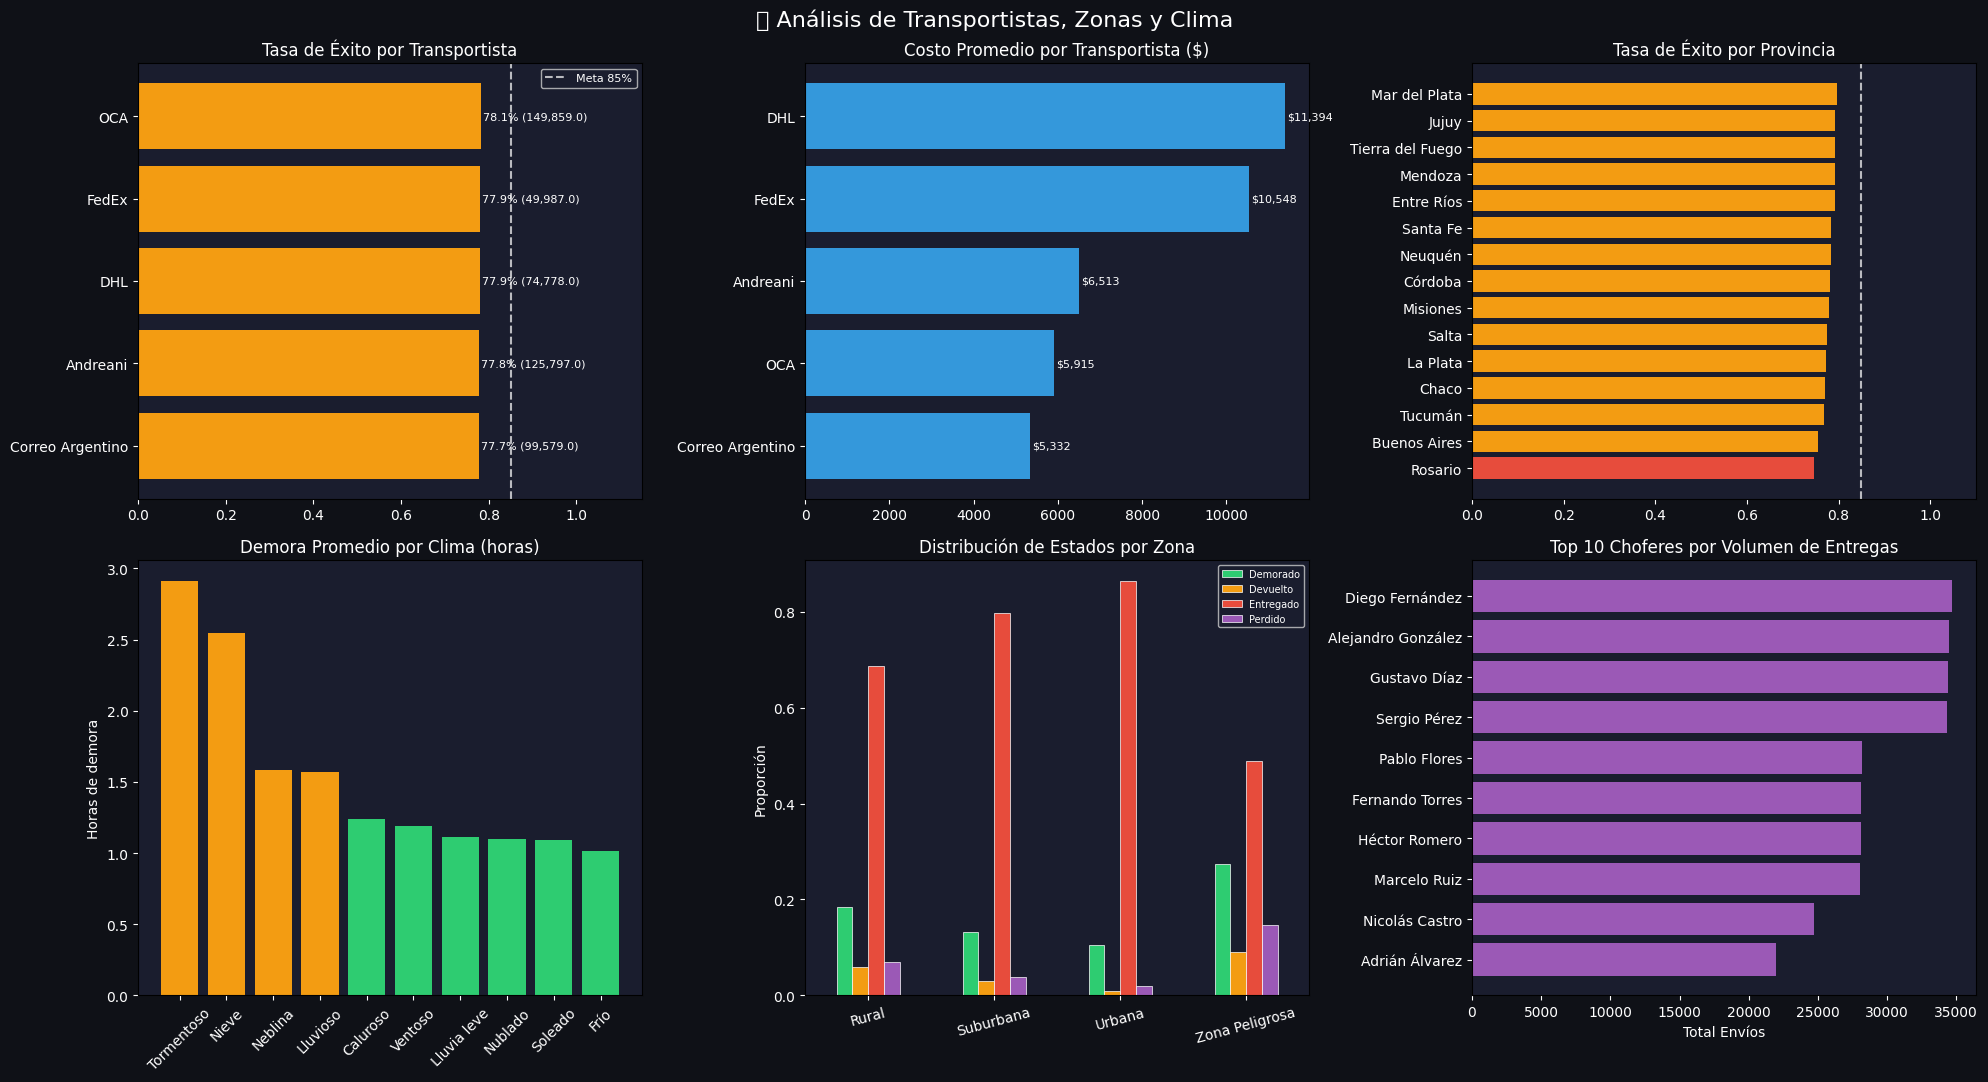

✅ Guardado: 02_transportistas_zonas_clima.png


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('🚚 Análisis de Transportistas, Zonas y Clima', fontsize=16)

# ── 1. Tasa éxito por transportista ──────────────────────
tasa_trans = df.groupby('transportista').agg(
    tasa=('entrega_exitosa', 'mean'),
    total=('shipment_id', 'count')
).sort_values('tasa')

colores_t = ['#e74c3c' if t < 0.75 else '#f39c12'
             if t < 0.85 else '#2ecc71' for t in tasa_trans['tasa']]
bars = axes[0,0].barh(tasa_trans.index, tasa_trans['tasa'], color=colores_t)
axes[0,0].axvline(x=0.85, color='white', linestyle='--', alpha=0.7, label='Meta 85%')
for bar, (_, row) in zip(bars, tasa_trans.iterrows()):
    axes[0,0].text(row['tasa'] + 0.005, bar.get_y() + bar.get_height()/2,
                   f"{row['tasa']:.1%} ({row['total']:,})",
                   va='center', fontsize=8)
axes[0,0].set_title('Tasa de Éxito por Transportista')
axes[0,0].set_xlim(0, 1.15)
axes[0,0].legend(fontsize=8)

# ── 2. Costo promedio por transportista ──────────────────
costo_trans = df.groupby('transportista')['costo_envio'].mean().sort_values()
axes[0,1].barh(costo_trans.index, costo_trans.values, color='#3498db')
for i, (trans, costo) in enumerate(costo_trans.items()):
    axes[0,1].text(costo + 50, i, f'${costo:,.0f}', va='center', fontsize=8)
axes[0,1].set_title('Costo Promedio por Transportista ($)')

# ── 3. Tasa éxito por zona y provincia ───────────────────
tasa_prov = df.groupby('provincia')['entrega_exitosa'].mean().sort_values()
colores_p = ['#e74c3c' if t < 0.75 else '#f39c12'
             if t < 0.85 else '#2ecc71' for t in tasa_prov]
axes[0,2].barh(tasa_prov.index, tasa_prov.values, color=colores_p)
axes[0,2].axvline(x=0.85, color='white', linestyle='--', alpha=0.7)
axes[0,2].set_title('Tasa de Éxito por Provincia')
axes[0,2].set_xlim(0, 1.1)

# ── 4. Impacto del clima en demora ────────────────────────
demora_clima = df.groupby('clima')['demora_horas'].mean().sort_values(ascending=False)
colores_c = ['#e74c3c' if d > 3 else '#f39c12'
             if d > 1.5 else '#2ecc71' for d in demora_clima]
axes[1,0].bar(demora_clima.index, demora_clima.values, color=colores_c)
axes[1,0].set_title('Demora Promedio por Clima (horas)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Horas de demora')

# ── 5. Distribución estados por zona ─────────────────────
estados_zona = df.groupby(['zona', 'estado']).size().unstack(fill_value=0)
estados_zona_pct = estados_zona.div(estados_zona.sum(axis=1), axis=0)
colores_estados  = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
estados_zona_pct.plot(kind='bar', ax=axes[1,1], color=colores_estados,
                       edgecolor='white', linewidth=0.5)
axes[1,1].set_title('Distribución de Estados por Zona')
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='x', rotation=15)
axes[1,1].legend(fontsize=7, loc='upper right')
axes[1,1].set_ylabel('Proporción')

# ── 6. Top 10 choferes con más entregas ──────────────────
if 'chofer' in df.columns:
    top_choferes = df.groupby('chofer').agg(
        total=('shipment_id', 'count'),
        tasa=('entrega_exitosa', 'mean')
    ).sort_values('total', ascending=False).head(10)

    axes[1,2].barh(top_choferes.index[::-1],
                   top_choferes['total'].values[::-1], color='#9b59b6')
    axes[1,2].set_title('Top 10 Choferes por Volumen de Entregas')
    axes[1,2].set_xlabel('Total Envíos')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "02_transportistas_zonas_clima.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: 02_transportistas_zonas_clima.png")

In [7]:
print("\n" + "=" * 60)
print("✅ EXPLORACIÓN INICIAL COMPLETADA")
print("=" * 60)

print(f"""
📊 RESUMEN DEL DATASET:
   Total registros     : {len(df):,}
   Período             : 2022 → 2024
   Columnas            : {len(df.columns)}
   Valores nulos       : {df.isnull().sum().sum():,}
   Duplicados          : {df.duplicated().sum():,}

🎯 HALLAZGOS CLAVE:
   Tasa éxito global   : {df['entrega_exitosa'].mean():.1%}
   Mejor transportista : {df.groupby('transportista')['entrega_exitosa'].mean().idxmax()}
   Peor zona           : {df.groupby('zona')['entrega_exitosa'].mean().idxmin()}
   Clima más dañino    : {df.groupby('clima')['demora_horas'].mean().idxmax()}
   Mes con más envíos  : {df.groupby('mes').size().idxmax()}
   Evento más activo   : {df['evento_especial'].value_counts().idxmax()}

💰 IMPACTO ECONÓMICO:
   Costo promedio 2022 : ${df[df['anio']==2022]['costo_envio'].mean():,.0f}
   Costo promedio 2023 : ${df[df['anio']==2023]['costo_envio'].mean():,.0f}
   Costo promedio 2024 : ${df[df['anio']==2024]['costo_envio'].mean():,.0f}

📁 ARCHIVOS GENERADOS:
   → outputnts/figures/01_estacionalidad_eventos.png
   → outputnts/figures/02_transportistas_zonas_clima.png
   → outputnts/reports/kpis_principales.csv
""")


✅ EXPLORACIÓN INICIAL COMPLETADA

📊 RESUMEN DEL DATASET:
   Total registros     : 500,000
   Período             : 2022 → 2024
   Columnas            : 23
   Valores nulos       : 389,506
   Duplicados          : 0

🎯 HALLAZGOS CLAVE:
   Tasa éxito global   : 77.9%
   Mejor transportista : OCA
   Peor zona           : Zona Peligrosa
   Clima más dañino    : Tormentoso
   Mes con más envíos  : 12
   Evento más activo   : Normal

💰 IMPACTO ECONÓMICO:
   Costo promedio 2022 : $3,219
   Costo promedio 2023 : $6,263
   Costo promedio 2024 : $12,223

📁 ARCHIVOS GENERADOS:
   → outputnts/figures/01_estacionalidad_eventos.png
   → outputnts/figures/02_transportistas_zonas_clima.png
   → outputnts/reports/kpis_principales.csv

